<a href="https://colab.research.google.com/github/AhnJG/AI-Project/blob/master/Colab/regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*회귀*(regression)는 가격이나 확률 같이 연속된 출력 값을 예측하는 것이 목적입니다. 이와는 달리 *분류*(classification)는 여러개의 클래스 중 하나의 클래스를 선택하는 것이 목적입니다(예를 들어, 사진에 사과 또는 오렌지가 포함되어 있을 때 어떤 과일인지 인식하는 것).

이 노트북은 [Auto MPG](https://archive.ics.uci.edu/ml/datasets/auto+mpg) 데이터셋을 사용하여 1970년대 후반과 1980년대 초반의 자동차 연비를 예측하는 모델을 만듭니다. 이 기간에 출시된 자동차 정보를 모델에 제공하겠습니다. 이 정보에는 실린더 수, 배기량, 마력(horsepower), 공차 중량 같은 속성이 포함됩니다.

이 예제는 `tf.keras` API를 사용합니다. 자세한 내용은 [케라스 가이드](https://www.tensorflow.org/guide/keras)를 참고하세요.

In [1]:
# 산점도 행렬을 그리기 위해 seaborn 패키지 설치
!pip install seaborn

In [1]:
from __future__ import absolute_import, print_function, division, unicode_literals

import pathlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

try:
    %tensorflow_version 2.x
except Exception:
    pass

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

TensorFlow 2.x selected.
2.1.0-rc1


## Auto MPG 데이터셋

이 데이터셋은 [UCI 머신 러닝 저장소](https://archive.ics.uci.edu/ml/)에서 다운로드할 수 있습니다.

### 데이터 구하기
먼저 데이터셋을 다운로드합니다.

In [2]:
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

32768/30286 [================================] - 0s 1us/step


'/root/.keras/datasets/auto-mpg.data'

판다스를 사용하여 데이터를 읽습니다.

In [3]:
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration', 'Model year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                          na_values="?", comment='\t', 
                          sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


### 데이터 정제하기

이 데이터셋은 일부 데이터가 누락되어 있습니다.

In [4]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model year      0
Origin          0
dtype: int64

문제를 간단하게 만들기 위해서 누락된 행을 삭제하겠습니다.

In [0]:
dataset = dataset.dropna()

`"Origin"` 열은 수치형이 아니고 범주형이므로 원-핫 인코딩(one-hot encoding)으로 변환하겠습니다:

In [0]:
origin = dataset.pop('Origin')

In [8]:
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model year
393,27.0,4,140.0,86.0,2790.0,15.6,82
394,44.0,4,97.0,52.0,2130.0,24.6,82
395,32.0,4,135.0,84.0,2295.0,11.6,82
396,28.0,4,120.0,79.0,2625.0,18.6,82
397,31.0,4,119.0,82.0,2720.0,19.4,82


In [9]:
dataset['USA'] = (origin == 1) * 1.0
dataset['Europe'] = (origin == 2) * 1.0
dataset['Japan'] = (origin == 3) * 1.0
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


### 데이터셋을 훈련 세트와 테스트 세트로 분할하기

이제 데이터를 훈련 세트와 테스트 세트로 분할합니다.

테스트 세트는 모델을 최종적으로 평가할 때 사용합니다.

In [0]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [15]:
print(len(dataset), len(train_dataset), len(test_dataset))

392 314 78


### 데이터 조사하기

훈련 세트에서 몇 개의 열을 선택해 산점도 행렬을 만들어 살펴 보겠습니다.

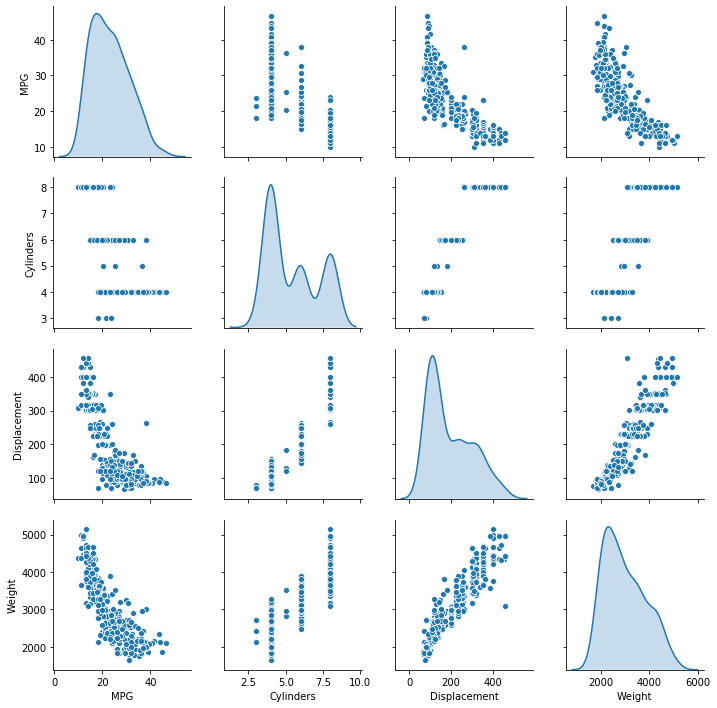

In [16]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

전반적인 통계도 확인해 보죠:

In [20]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


### 특성과 레이블 분리하기

특성에서 타깃 값 또는 "레이블"을 분리합니다. 이 레이블을 예측하기 위해 모델을 훈련시킬 것입니다.

In [0]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

In [24]:
train_labels
test_labels

9      15.0
25     10.0
28      9.0
31     25.0
33     19.0
       ... 
369    34.0
375    36.0
382    34.0
384    32.0
396    28.0
Name: MPG, Length: 78, dtype: float64

### 데이터 정규화

위 `train_stats` 통계를 다시 살펴보고 각 특성의 범위가 얼마나 다른지 확인해 보죠.

특성의 스케일과 범위가 다르면 정규화(normalization)하는 것이 권장됩니다. 특성을 정규화하지 않아도 모델이 *수렴할 수 있지만*, 훈련시키기 어렵고 입력 단위에 의존적인 모델이 만들어집니다.

노트: 의도적으로 훈련 세트만 사용하여 통계치를 생성했습니다. 이 통계는 테스트 세트를 정규화할 때에도 사용됩니다. 이는 테스트 세트를 모델이 훈련에 사용했던 것과 동일한 분포로 투영하기 위해서입니다.

In [27]:
print(train_stats['std'])
train_dataset

Cylinders         1.699788
Displacement    104.331589
Horsepower       38.096214
Weight          843.898596
Acceleration      2.789230
Model year        3.675642
USA               0.485101
Europe            0.383413
Japan             0.398712
Name: std, dtype: float64


,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model year,USA,Europe,Japan
146,4,90.0,75.0,2125.0,14.5,74,1.0,0.0,0.0
282,4,140.0,88.0,2890.0,17.3,79,1.0,0.0,0.0
69,8,350.0,160.0,4456.0,13.5,72,1.0,0.0,0.0
378,4,105.0,63.0,2125.0,14.7,82,1.0,0.0,0.0
331,4,97.0,67.0,2145.0,18.0,80,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...
281,6,200.0,85.0,2990.0,18.2,79,1.0,0.0,0.0
229,8,400.0,180.0,4220.0,11.1,77,1.0,0.0,0.0
150,4,108.0,93.0,2391.0,15.5,74,0.0,0.0,1.0
145,4,83.0,61.0,2003.0,19.0,74,0.0,0.0,1.0


In [0]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

정규화된 데이터를 사용하여 모델을 훈련합니다.

주의: 여기에서 입력 데이터를 정규화하기 위해 사용한 통계치(평균과 표준편차)는 원-핫 인코딩과 마찬가지로 모델에 주입되는 모든 데이터에 적용되어야 합니다. 여기에는 테스트 세트는 물론 모델이 실전에 투입되어 얻은 라이브 데이터도 포함됩니다.

## 모델

### 모델 만들기

모델을 구성해 보죠. 여기에서는 두 개의 완전 연결(densely connected) 은닉층으로 `Sequential` 모델을 만들겠습니다. 출력 층은 하나의 연속적인 값을 반환합니다. 나중에 두 번째 모델을 만들기 쉽도록 `build_model` 함수로 모델 구성 단계를 감싸겠습니다.

In [0]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=['mae', 'mse'])
    return model
    

In [0]:
model = build_model()

### 모델 확인

`.summary` 메서드를 사용해 모델에 대한 간단한 정보를 출력합니다.

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


모델을 한번 실행해 보죠. 훈련 세트에서 `10` 샘플을 하나의 배치로 만들어 `model.predict` 메서드를 호출해 보겠습니다.

In [32]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[ 0.50393355],
       [ 0.14312041],
       [ 0.32848722],
       [ 0.3789274 ],
       [ 0.02072888],
       [ 0.22450751],
       [-0.03433121],
       [ 0.62637997],
       [ 0.1996841 ],
       [-0.21904698]], dtype=float32)

제대로 작동하는 것 같네요. 결괏값의 크기와 타입이 기대했던 대로입니다.

### 모델 훈련

이 모델을 1,000번의 에포크(epoch) 동안 훈련합니다. 훈련 정확도와 검증 정확도는 `history` 객체에 기록됩니다.

In [33]:
# 에포크가 끝날 때마자 점(.)을 출력해 훈련 진행 과정을 표시합니다
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

EPOCHS = 1000

history = model.fit(
    normed_train_data, train_labels,
    epochs = EPOCHS, validation_split=0.2, verbose=0,
    callbacks=[PrintDot()]
)


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

`history` 객체에 저장된 통계치를 사용해 모델의 훈련 과정을 시각화해 보죠.

In [34]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,2.287053,0.972714,2.287053,8.269843,2.144312,8.269843,995
996,2.484914,1.042756,2.484914,7.921413,2.173626,7.921413,996
997,2.323079,1.005160,2.323079,8.462315,2.282212,8.462316,997
998,2.334658,0.974454,2.334657,7.938364,2.203513,7.938364,998
999,2.200866,0.941821,2.200866,8.144772,2.247262,8.144772,999


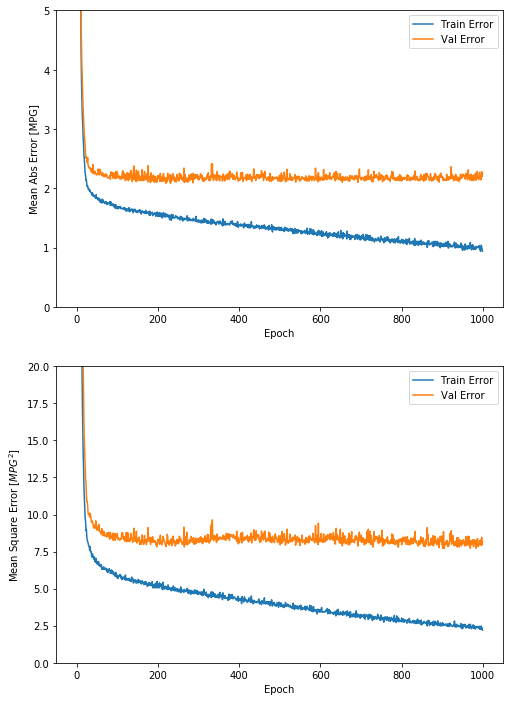

In [35]:
import matplotlib.pyplot as plt

def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure(figsize=(8,12))

    plt.subplot(2, 1, 1)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'], hist['mae'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'], label='Val Error')
    plt.ylim([0, 5])
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(hist['epoch'], hist['mse'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'], label='Val Error')
    plt.ylim([0, 20])
    plt.legend()
    plt.show()

plot_history(history)

이 그래프를 보면 수 백번 에포크를 진행한 이후에는 모델이 거의 향상되지 않는 것 같습니다. `model.fit` 메서드를 수정하여 검증 점수가 향상되지 않으면 자동으로 훈련을 멈추도록 만들어 보죠. 에포크마다 훈련 상태를 점검하기 위해 *EarlyStopping 콜백(callback)*을 사용하겠습니다. 지정된 에포크 횟수 동안 성능 향상이 없으면 자동으로 훈련이 멈춥니다.

이 콜백에 대해 더 자세한 내용은 [여기](https://www.tensorflow.org/versions/master/api_docs/python/tf/keras/callbacks/EarlyStopping)를 참고하세요.


.......................................................

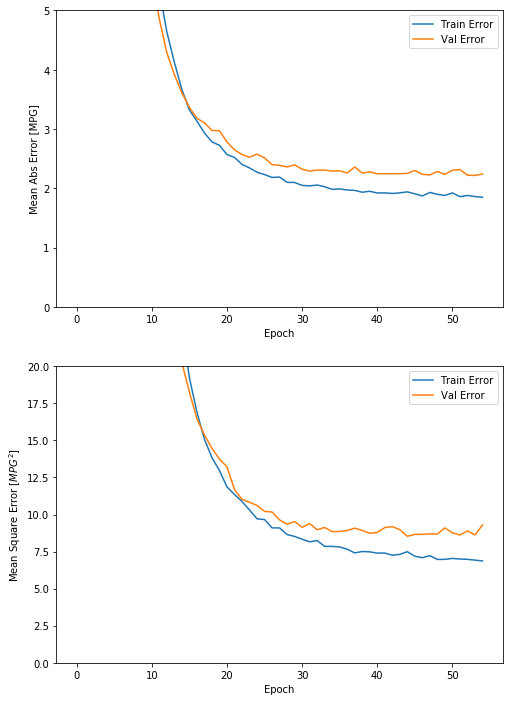

In [37]:
model = build_model()

# patience 매개변수는 성능 향상을 체크할 에포크 횟수입니다.
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(normed_train_data, train_labels, epochs=EPOCHS, validation_split=0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

이 그래프를 보면 검증 세트의 평균 오차가 약 +/- 2 MPG입니다. 좋은 결과인가요? 이에 대한 평가는 여러분에게 맡기겠습니다.

모델을 훈련할 때 사용하지 않았던 **테스트 세트**에서 모델의 성능을 확인해 보죠. 이를 통해 모델이 실전에 투입되었을 때 모델의 성능을 짐작할 수 있습니다:

In [38]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("테스트 세트의 평균 절대 오차: {:5.2f} MPG".format(mae))

78/78 - 0s - loss: 6.8051 - mae: 2.0508 - mse: 6.8051
테스트 세트의 평균 절대 오차:  2.05 MPG


## 예측

마지막으로 테스트 세트에 있는 샘플을 사용해 MPG 값을 예측해 보겠습니다:

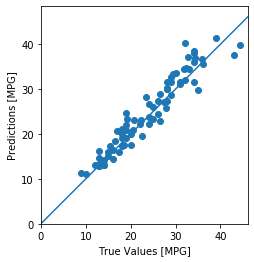

In [39]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0, plt.xlim()[1]])
plt.ylim([0, plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

모델이 꽤 잘 예측한 것 같습니다. 오차의 분포를 살펴 보죠.

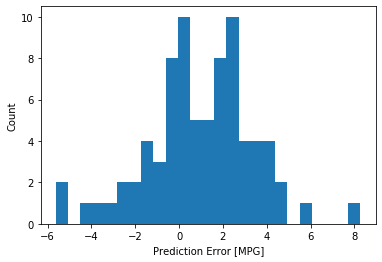

In [40]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

가우시안 분포가 아니지만 아마도 훈련 샘플의 수가 매우 작기 때문일 것입니다.

## 결론

이 노트북은 회귀 문제를 위한 기법을 소개합니다.

* 평균 제곱 오차(MSE)는 회귀 문제에서 자주 사용하는 손실 함수입니다(분류 문제에서 사용하는 손실 함수와 다릅니다).
* 비슷하게 회귀에서 사용되는 평가 지표도 분류와 다릅니다. 많이 사용하는 회귀 지표는 평균 절댓값 오차(MAE)입니다.
* 수치 입력 데이터의 특성이 여러 가지 범위를 가질 때 동일한 범위가 되도록 각 특성의 스케일을 독립적으로 조정해야 합니다.
* 훈련 데이터가 많지 않다면 과대적합을 피하기 위해 은닉층의 개수가 적은 소규모 네트워크를 선택하는 방법이 좋습니다.
* 조기 종료(Early stopping)은 과대적합을 방지하기 위한 좋은 방법입니다.